# IF3070 Pemrogaman Data Analitik | Tugas Besar


Group Number: 10

Group Members:
- Abdullah Mubarak (13522101)
- Viody Alfaridzi (23525039)
- Iskandar Muda Rizky Parlambang (23525058)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import chi2_contingency
from sklearn.base import OneToOneFeatureMixin
from sklearn.utils._set_output import _SetOutputMixin
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [ ]:
df = pd.read_csv('hotel_bookings.csv')
df = df.sort_values('reservation_status_date')

train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

Pembagian untuk train dan test dilakukan berdasarkan urutan waktu reservasi.

# 1. Exploratory Data Analysis

#### Initial Exploration

##### Size of the Data

In [ ]:
print(len(df_train))
print(len(df_train.columns))

95512
32


Terdapat 95512 instance data dengan 32 fitur.

##### Data Types

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95512 entries, 73829 to 107606
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           95512 non-null  object 
 1   is_canceled                     95512 non-null  int64  
 2   lead_time                       95512 non-null  int64  
 3   arrival_date_year               95512 non-null  int64  
 4   arrival_date_month              95512 non-null  object 
 5   arrival_date_week_number        95512 non-null  int64  
 6   arrival_date_day_of_month       95512 non-null  int64  
 7   stays_in_weekend_nights         95512 non-null  int64  
 8   stays_in_week_nights            95512 non-null  int64  
 9   adults                          95512 non-null  int64  
 10  children                        95508 non-null  float64
 11  babies                          95512 non-null  int64  
 12  meal                            

##### Unique Values in Categorical Features

In [ ]:
target_columns = ['is_canceled']
num_columns = [x for x in df_train.select_dtypes(include=['int64', 'float64']).columns.to_list() if x not in target_columns]
cat_columns = [x for x in df_train.columns if x not in num_columns and x not in target_columns]
print("Categorical columns: ")
print(cat_columns)
print("Numeric columns: ")
print(num_columns)

Categorical columns: 
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']
Numeric columns: 
['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [ ]:
for column in cat_columns:
    print("Column " + column + ":")
    print(df_train[column].value_counts())
    print()

Column hotel:
hotel
City Hotel      63473
Resort Hotel    32039
Name: count, dtype: int64

Column arrival_date_month:
arrival_date_month
October      11160
September    10508
August        9359
July          8132
February      8060
March         7756
April         7277
May           7201
November      6794
December      6780
June          6556
January       5929
Name: count, dtype: int64

Column meal:
meal
BB           75148
HB           11373
SC            7262
Undefined     1005
FB             724
Name: count, dtype: int64

Column country:
country
PRT    43035
GBR     8584
FRA     7886
ESP     6940
DEU     5157
       ...  
PYF        1
MYT        1
MDG        1
ASM        1
TGO        1
Name: count, Length: 165, dtype: int64

Column market_segment:
market_segment
Online TA        42501
Offline TA/TO    20494
Groups           17908
Direct            9433
Corporate         4443
Complementary      591
Aviation           140
Undefined            2
Name: count, dtype: int64

Column distr

Berdasarkan keterangan data, Undefined dan SC merepresentasikan hal yang sama. Namun, di dataset, keduanya dianggap jenis berbeda. Oleh karena itu, kedua jenis perlu digabungkan.

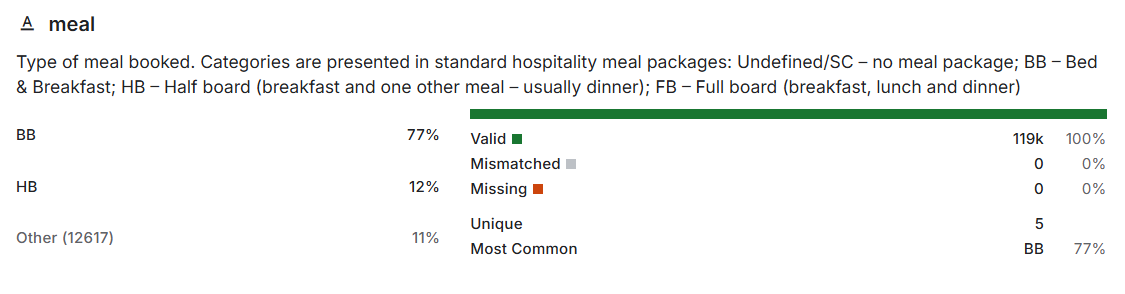

##### The Minimum, Maximum, Mean, Median, and Standard Deviation Values for Numeric Features

In [ ]:
df_train[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,95512.0,102.219732,106.932140,0.00,17.0,66.0,158.0000,737.0
arrival_date_year,95512.0,2015.945693,0.635090,2015.00,2016.0,2016.0,2016.0000,2017.0
arrival_date_week_number,95512.0,28.099694,14.667629,1.00,15.0,30.0,41.0000,53.0
arrival_date_day_of_month,95512.0,15.652180,8.762123,1.00,8.0,16.0,23.0000,31.0
stays_in_weekend_nights,95512.0,0.906399,0.997957,0.00,0.0,1.0,2.0000,19.0
stays_in_week_nights,95512.0,2.464874,1.899039,0.00,1.0,2.0,3.0000,50.0
adults,95512.0,1.842952,0.599374,0.00,2.0,2.0,2.0000,55.0
children,95508.0,0.094390,0.380700,0.00,0.0,0.0,0.0000,10.0
babies,95512.0,0.007989,0.099359,0.00,0.0,0.0,0.0000,10.0
is_repeated_guest,95512.0,0.031253,0.174001,0.00,0.0,0.0,0.0000,1.0


Dapat dilihat, nilai minimal kolom adults adalah 0. Hal ini mustahil terjadi kecuali pemesanan kosong atau palsu. Oleh karena itu, perlu dilakukan filtering untuk memastikan adults > 0.

##### Skewness

In [ ]:
skewness = df_train[num_columns].skew().abs()

skewness

,0
lead_time,1.359995
arrival_date_year,0.045149
arrival_date_week_number,0.153469
arrival_date_day_of_month,0.015691
stays_in_weekend_nights,1.474751
stays_in_week_nights,3.046951
adults,20.734764
children,4.373227
babies,26.924032
is_repeated_guest,5.387995


In [ ]:
skew_threshold = 1
highly_skewed_columns = skewness[skewness > skew_threshold].index.tolist()
print("Column with skewness > 1:", len(highly_skewed_columns))
print(highly_skewed_columns)

Column with skewness > 1: 15
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


Kebanyakan kolom numerik memiliki nilai skew yang tinggi sehingga imputasi yang lebih baik dilakukan adalah dengan median.

#### Cleaning Dataframe before Visualizing
Dilakukan beberapa pembersihan ke data sebelum eksplorasi lebih lanjut sesuai dengan hasil temuan sejauh ini.

In [ ]:
# 1. Drop pemesanan palsu
filter_guests = (df['adults']) == 0
df_clean = df[~filter_guests].copy()

# 2. Fix "Undefined" Meal Category (Undefined = SC)
df_clean['meal'].replace("Undefined", "SC", inplace=True)
print(f"Data before. Rows remaining: {len(df)}")
print(f"Data cleaned for EDA. Rows remaining: {len(df_clean)}")

Data before. Rows remaining: 119390
Data cleaned for EDA. Rows remaining: 118987


#### Missing Values for Each Feature

In [ ]:
missing_count = df_clean.isna().sum()
missing_percent = (df_clean.isna().sum() / len(df_clean)) * 100

missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_percent': missing_percent.round(2)
})

missing_df = missing_df[missing_df["missing_count"] > 0].sort_values('missing_percent', ascending=False)

missing_df

,missing_count,missing_percent
company,112221,94.31
agent,16263,13.67
country,478,0.40
children,4,0.00


Kolom company memiliki missing value sangat besar (94.15%), sehingga informasi perusahaan pemesan hampir tidak tersedia dan kemungkinan tidak berguna untuk pemodelan. Kolom agent memiliki missing 14.43%, cukup signifikan sehingga perlu dipertimbangkan strategi imputasi atau penghapusan. Kolom country hanya memiliki 0.49% missing, sehingga bisa diimputasi tanpa mengganggu kualitas data. Kolom lainnya tidak memiliki missing value sehingga aman digunakan langsung.

#### Distribution of Features

##### A. Distribution of Numerical Features

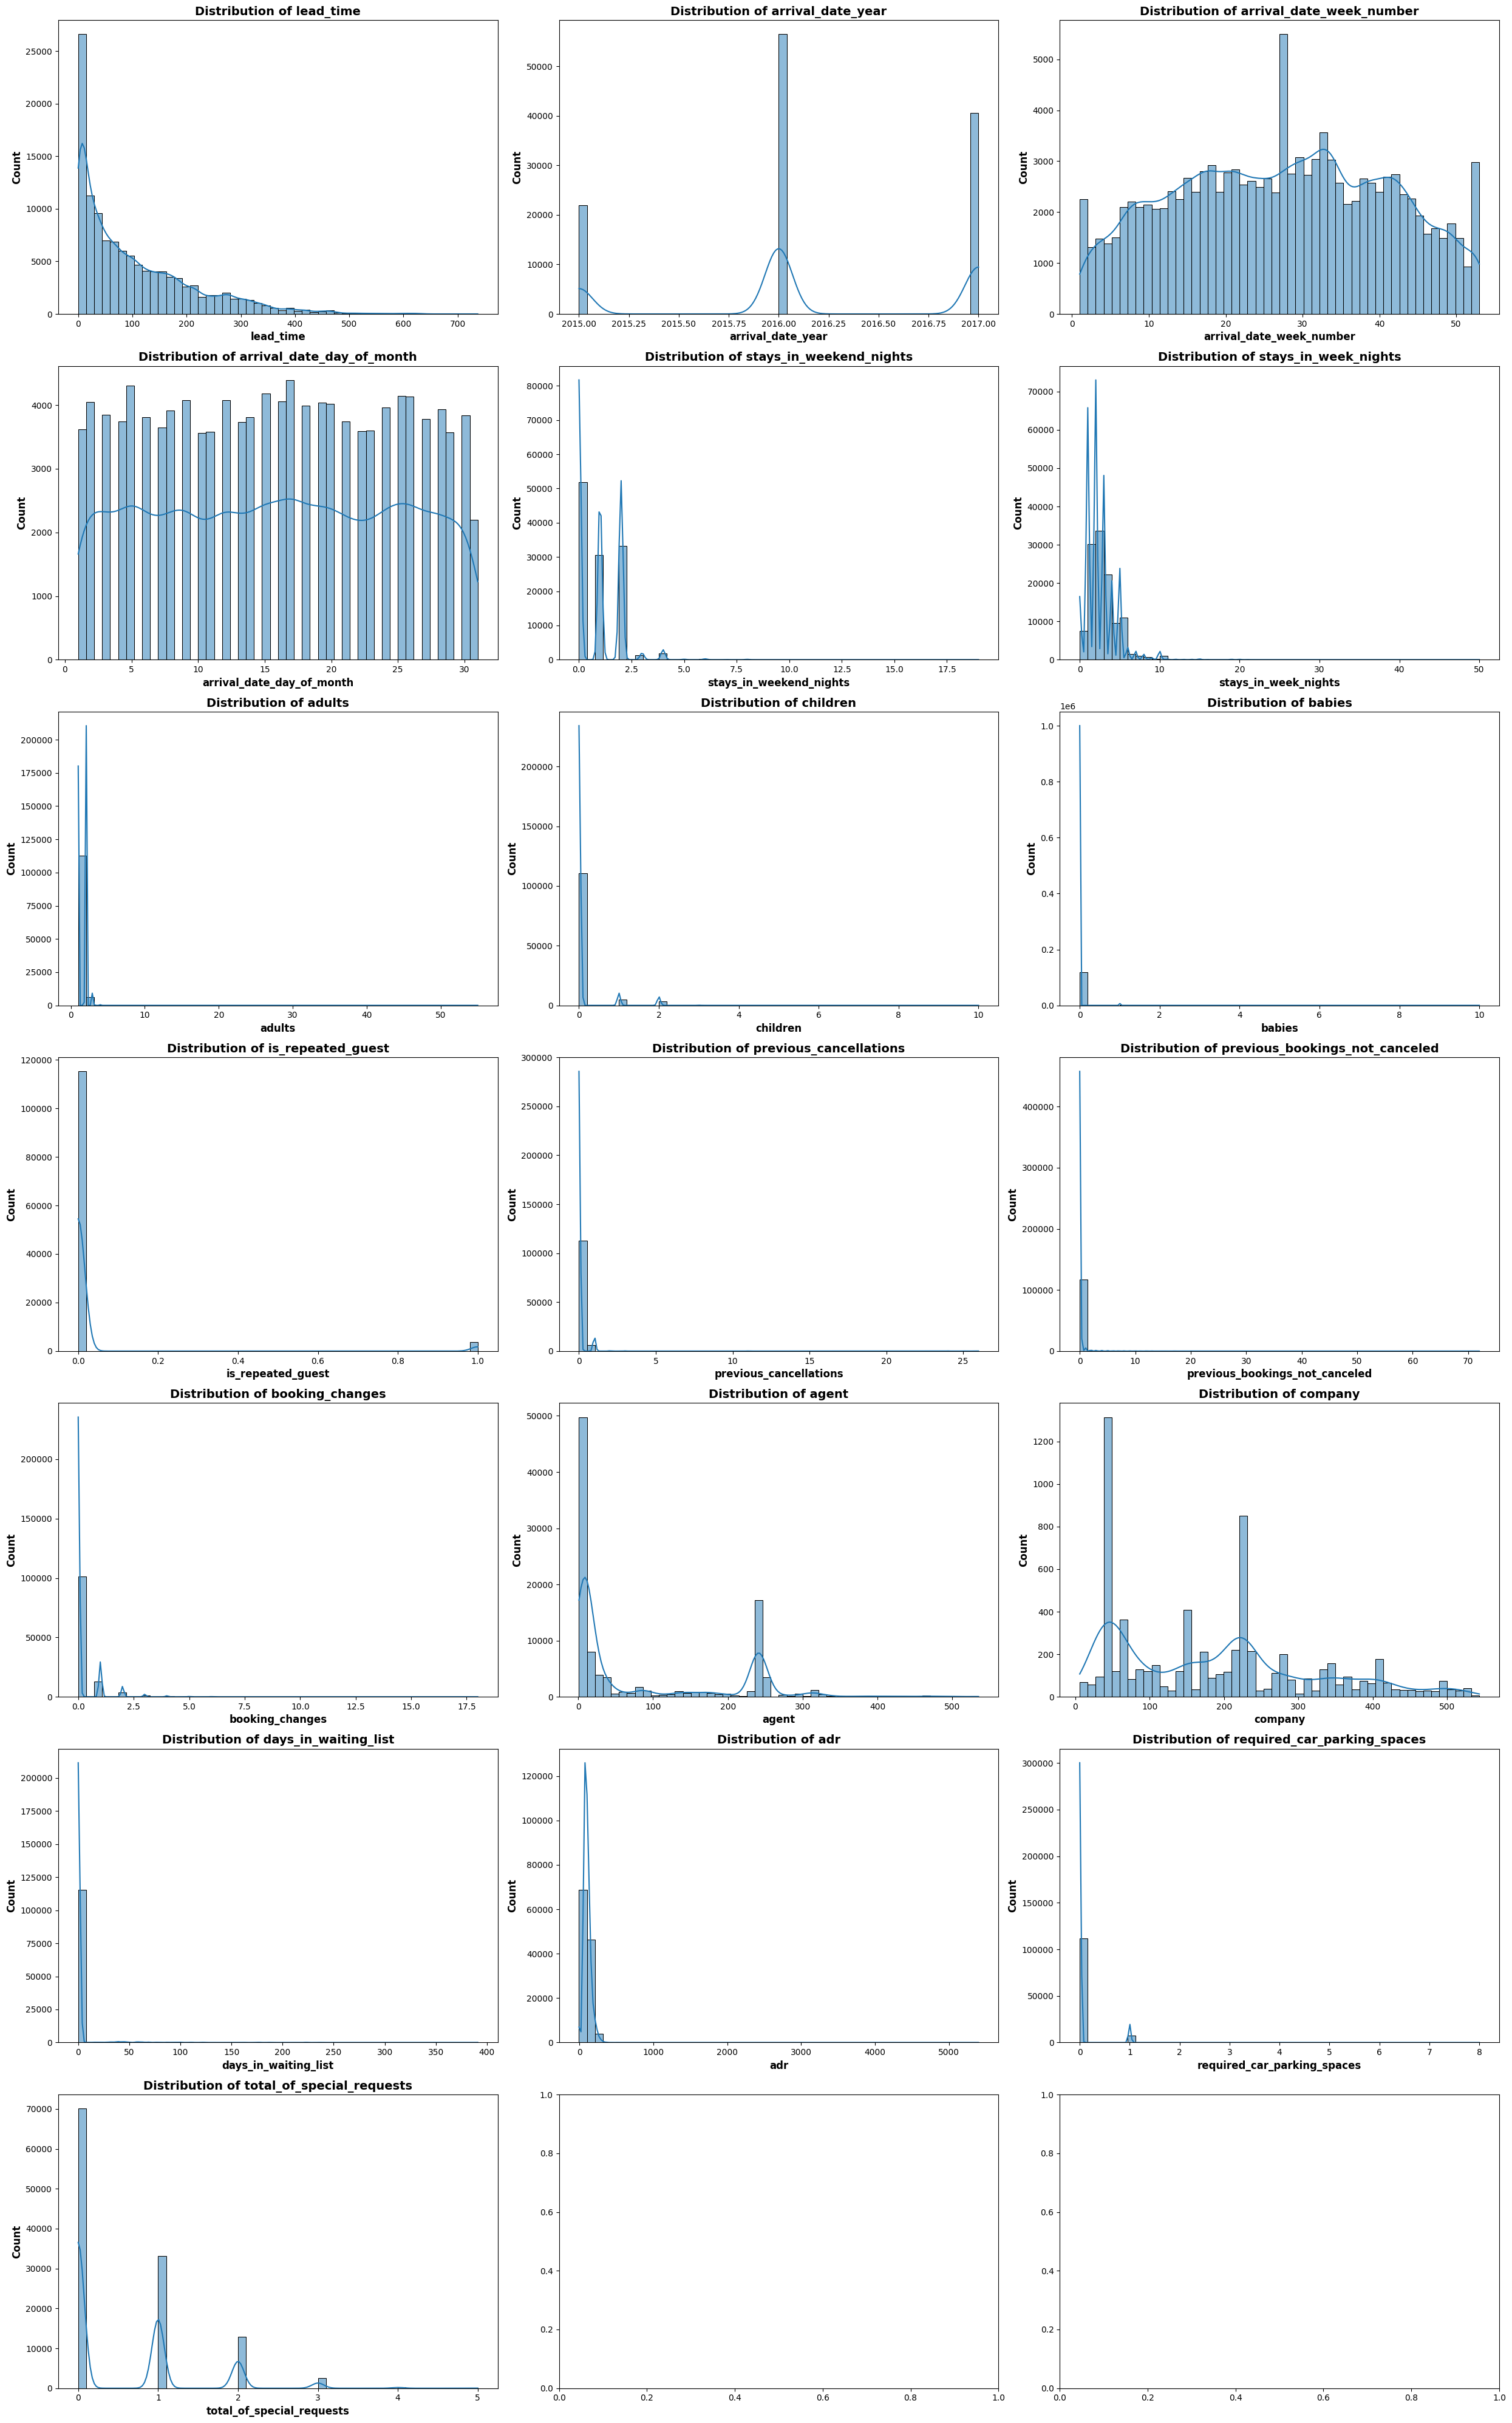

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(25, 40))

for i, column in enumerate(num_columns):
    row, col = divmod(i, 3)
    sns.histplot(df_clean[column], bins=50, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel(column, fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel('Count', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

##### B. Distribution of Categorical Features

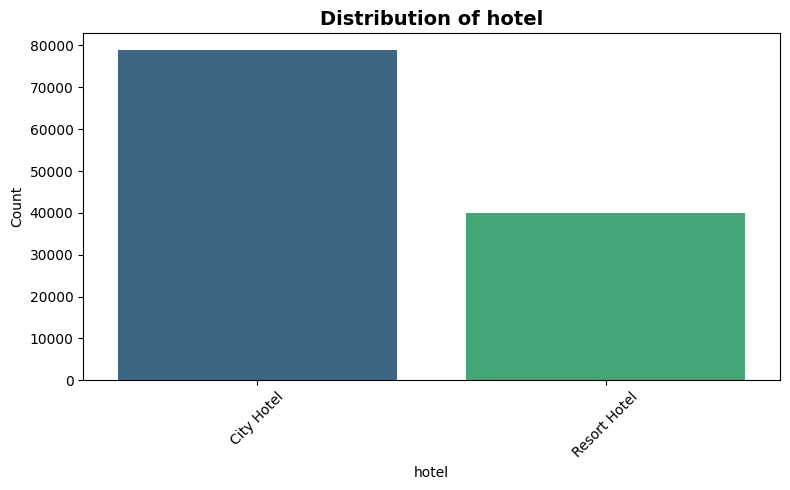

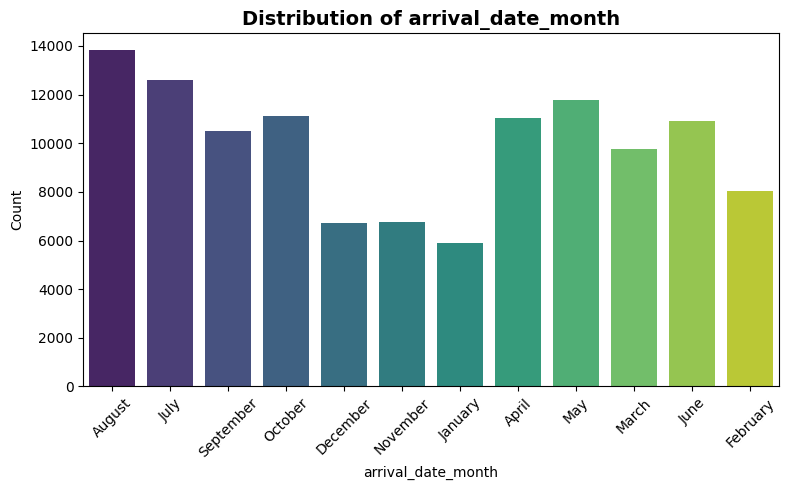

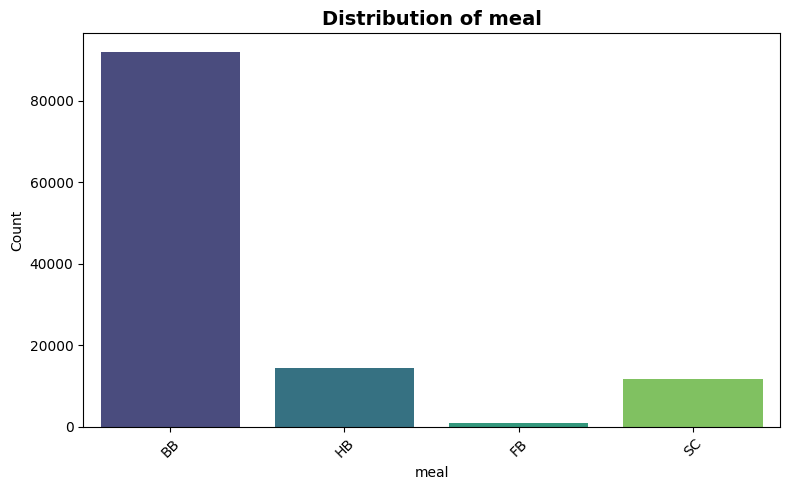

Visualizing High Cardinality Column: country (177 unique values)


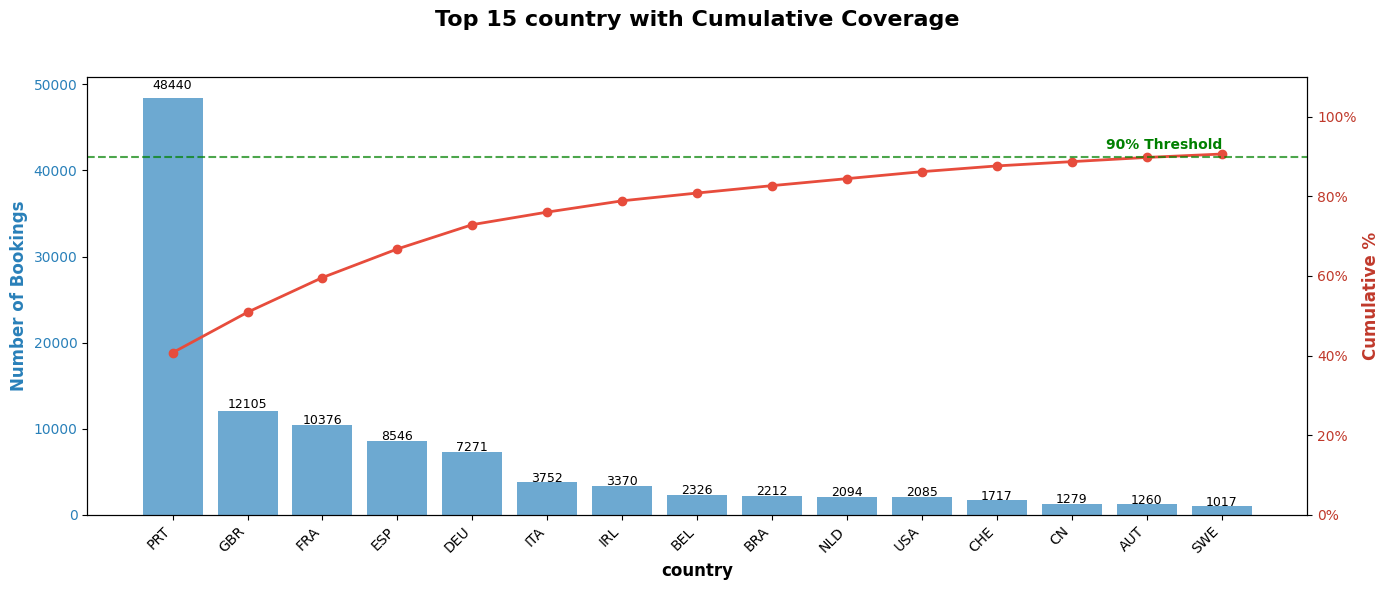

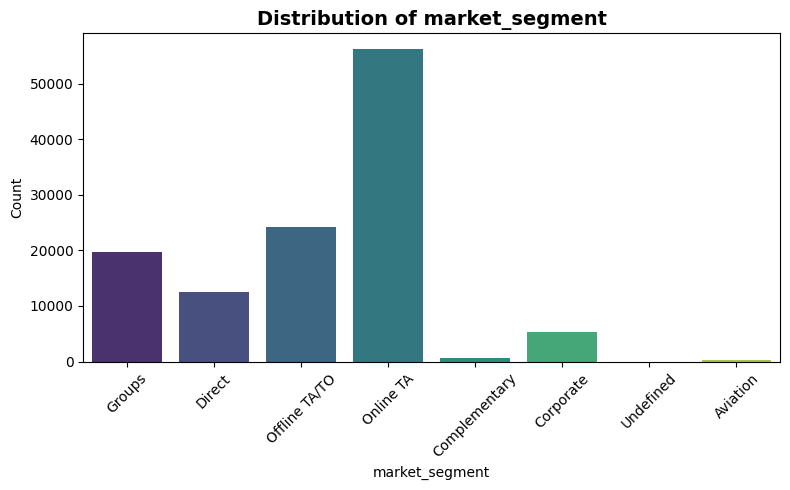

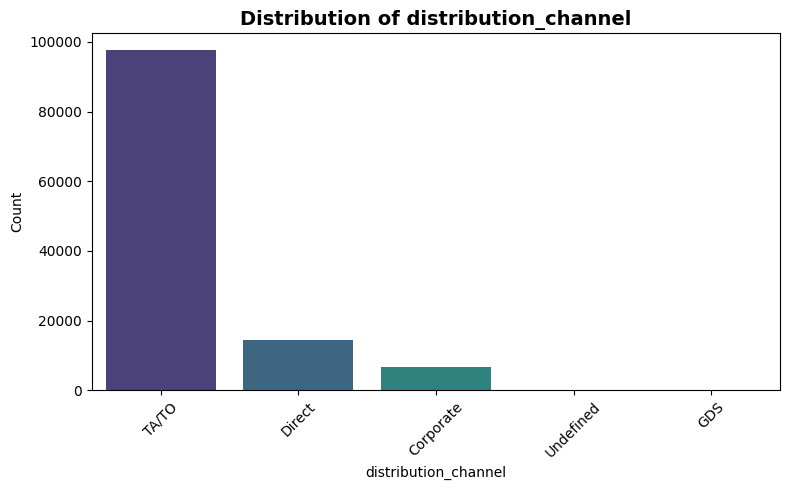

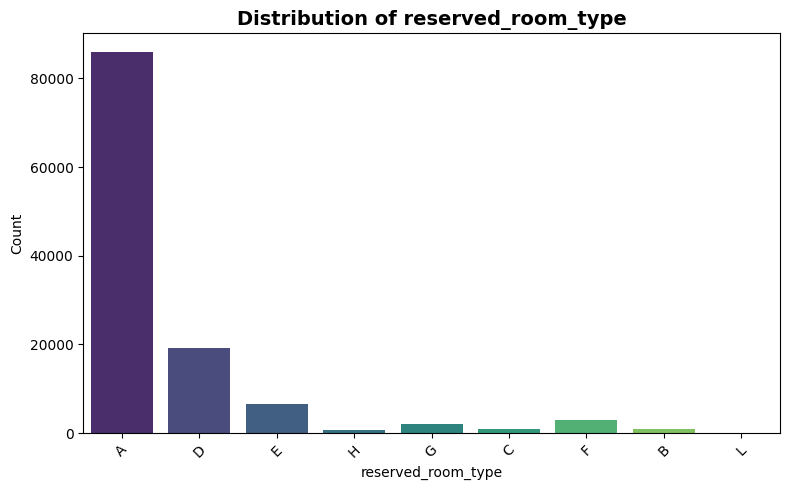

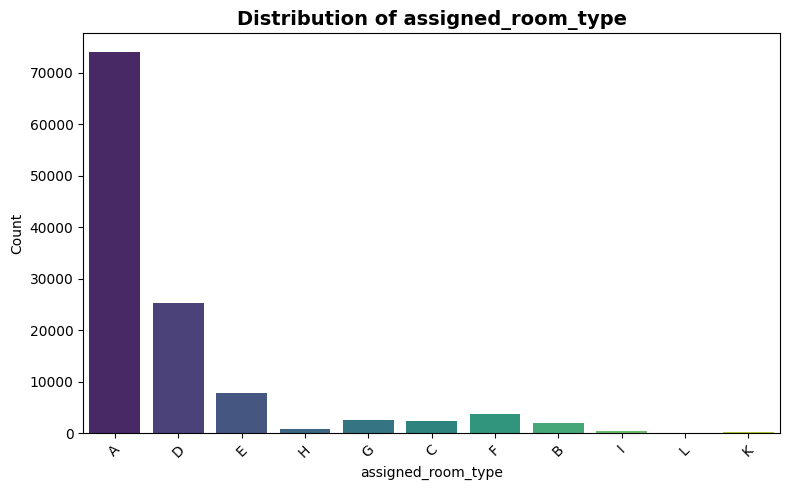

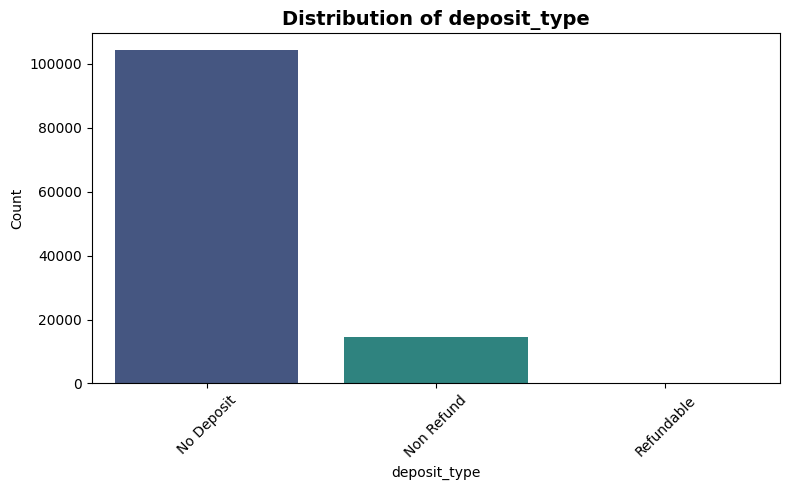

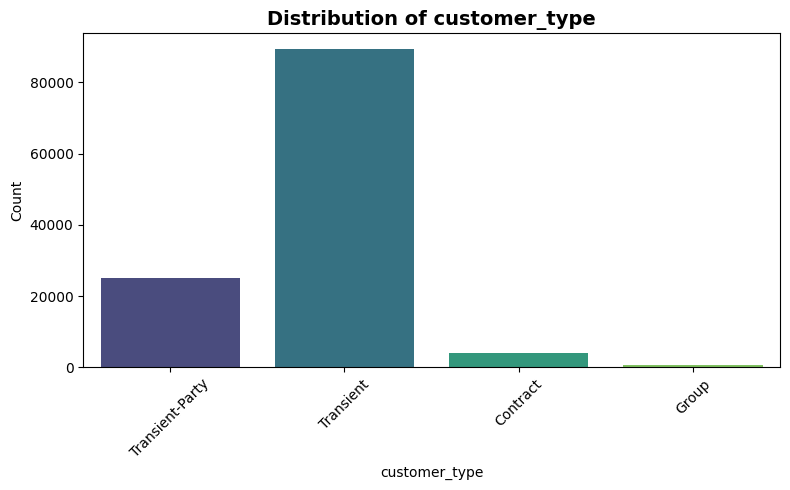

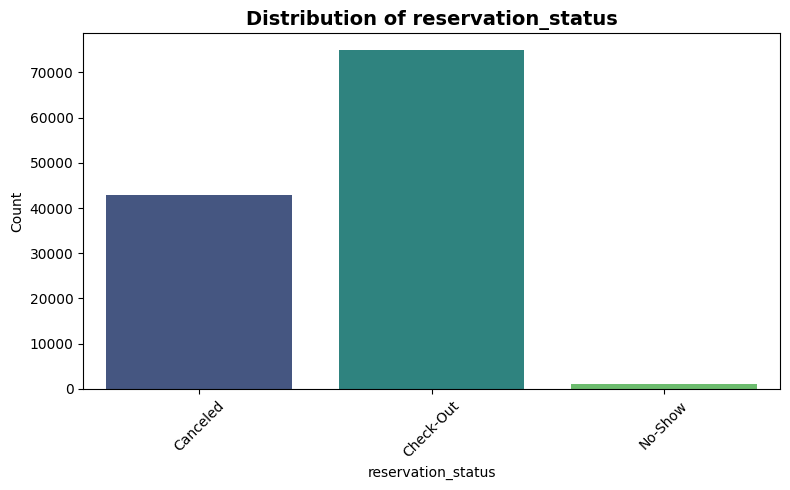

Visualizing High Cardinality Column: reservation_status_date (926 unique values)


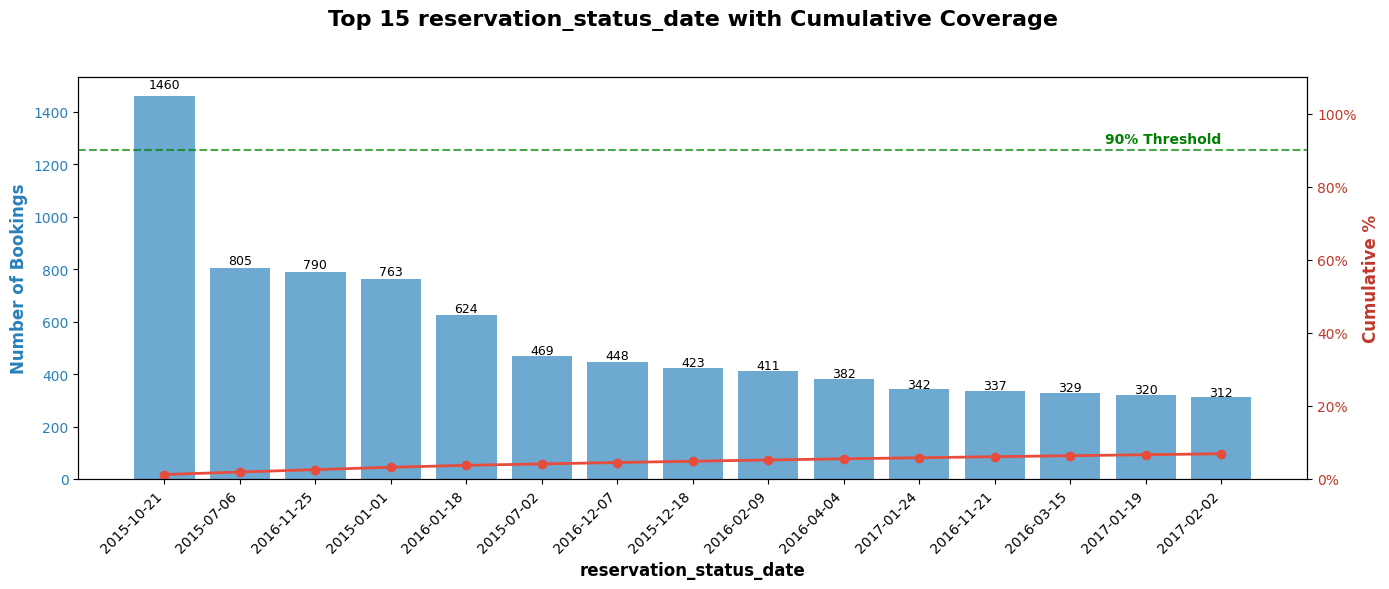

In [ ]:
import matplotlib.ticker as mtick

def plot_categorical_distribution(df, col, top_n=15):
    count_data = df[col].value_counts()

    top_data = count_data.head(top_n)

    total_count = len(df)
    cumulative_percent = (count_data.cumsum() / total_count) * 100

    cumulative_cut = cumulative_percent.loc[top_data.index]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Bar Chart (Count)
    sns.barplot(x=top_data.index, y=top_data.values, color='#3498db', ax=ax1, alpha=0.8)

    ax1.set_ylabel('Number of Bookings', fontsize=12, fontweight='bold', color='#2980b9')
    ax1.set_xlabel(col, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='#2980b9')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

    for i, v in enumerate(top_data.values):
        ax1.text(i, v + (v*0.02), str(v), ha='center', fontsize=9)

    # Line Chart (Cumulative Percentage)
    ax2 = ax1.twinx()
    ax2.plot(top_data.index, cumulative_cut.values, color='#e74c3c', marker='o', linewidth=2, linestyle='-')

    ax2.set_ylabel('Cumulative %', fontsize=12, fontweight='bold', color='#c0392b')
    ax2.tick_params(axis='y', labelcolor='#c0392b')
    ax2.set_ylim(0, 110)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    # Garis Threshold (Misal 90% atau 95%)
    ax2.axhline(90, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.text(len(top_data)-1, 92, '90% Threshold', color='green', fontweight='bold', ha='right')

    plt.title(f'Top {top_n} {col} with Cumulative Coverage\n',
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

for column in cat_columns:
    unique_count = df_clean[column].nunique()

    # Jika unique value terlalu banyak (> 20), gunakan Pareto Chart
    if unique_count > 20:
        print(f"Visualizing High Cardinality Column: {column} ({unique_count} unique values)")
        plot_categorical_distribution(df_clean, column, top_n=15)

    # Jika sedikit, gunakan Countplot biasa
    else:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df_clean[column], palette='viridis')
        plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Pada distribusi kolom Country didapat:
1. PRT (Portugal) mendominasi grafik secara ekstrem (sekitar 40-50% data).
2. Garis merah (Cumulative %) menunjukkan bahwa Top 10-15 negara saja sudah mencakup >90% dari total data.
3.  Dataset ini memiliki total sekitar 170+ negara. Grafik menunjukkan bahwa negara ke-16 sampai ke-177 memiliki frekuensi yang sangat kecil (bar-nya hampir tidak terlihat).

Membiarkan ratusan kolom negara kecil ini (jika di One-Hot Encode) hanya akan menambah noise dan beban komputasi (Curse of Dimensionality) tanpa memberikan pola yang signifikan.
Oleh karena itu, akan dilakukan penggabungan semua negara di luar Top 10/15 menjadi satu kategori "Other".

#### Correlation

##### Correlation Between Features

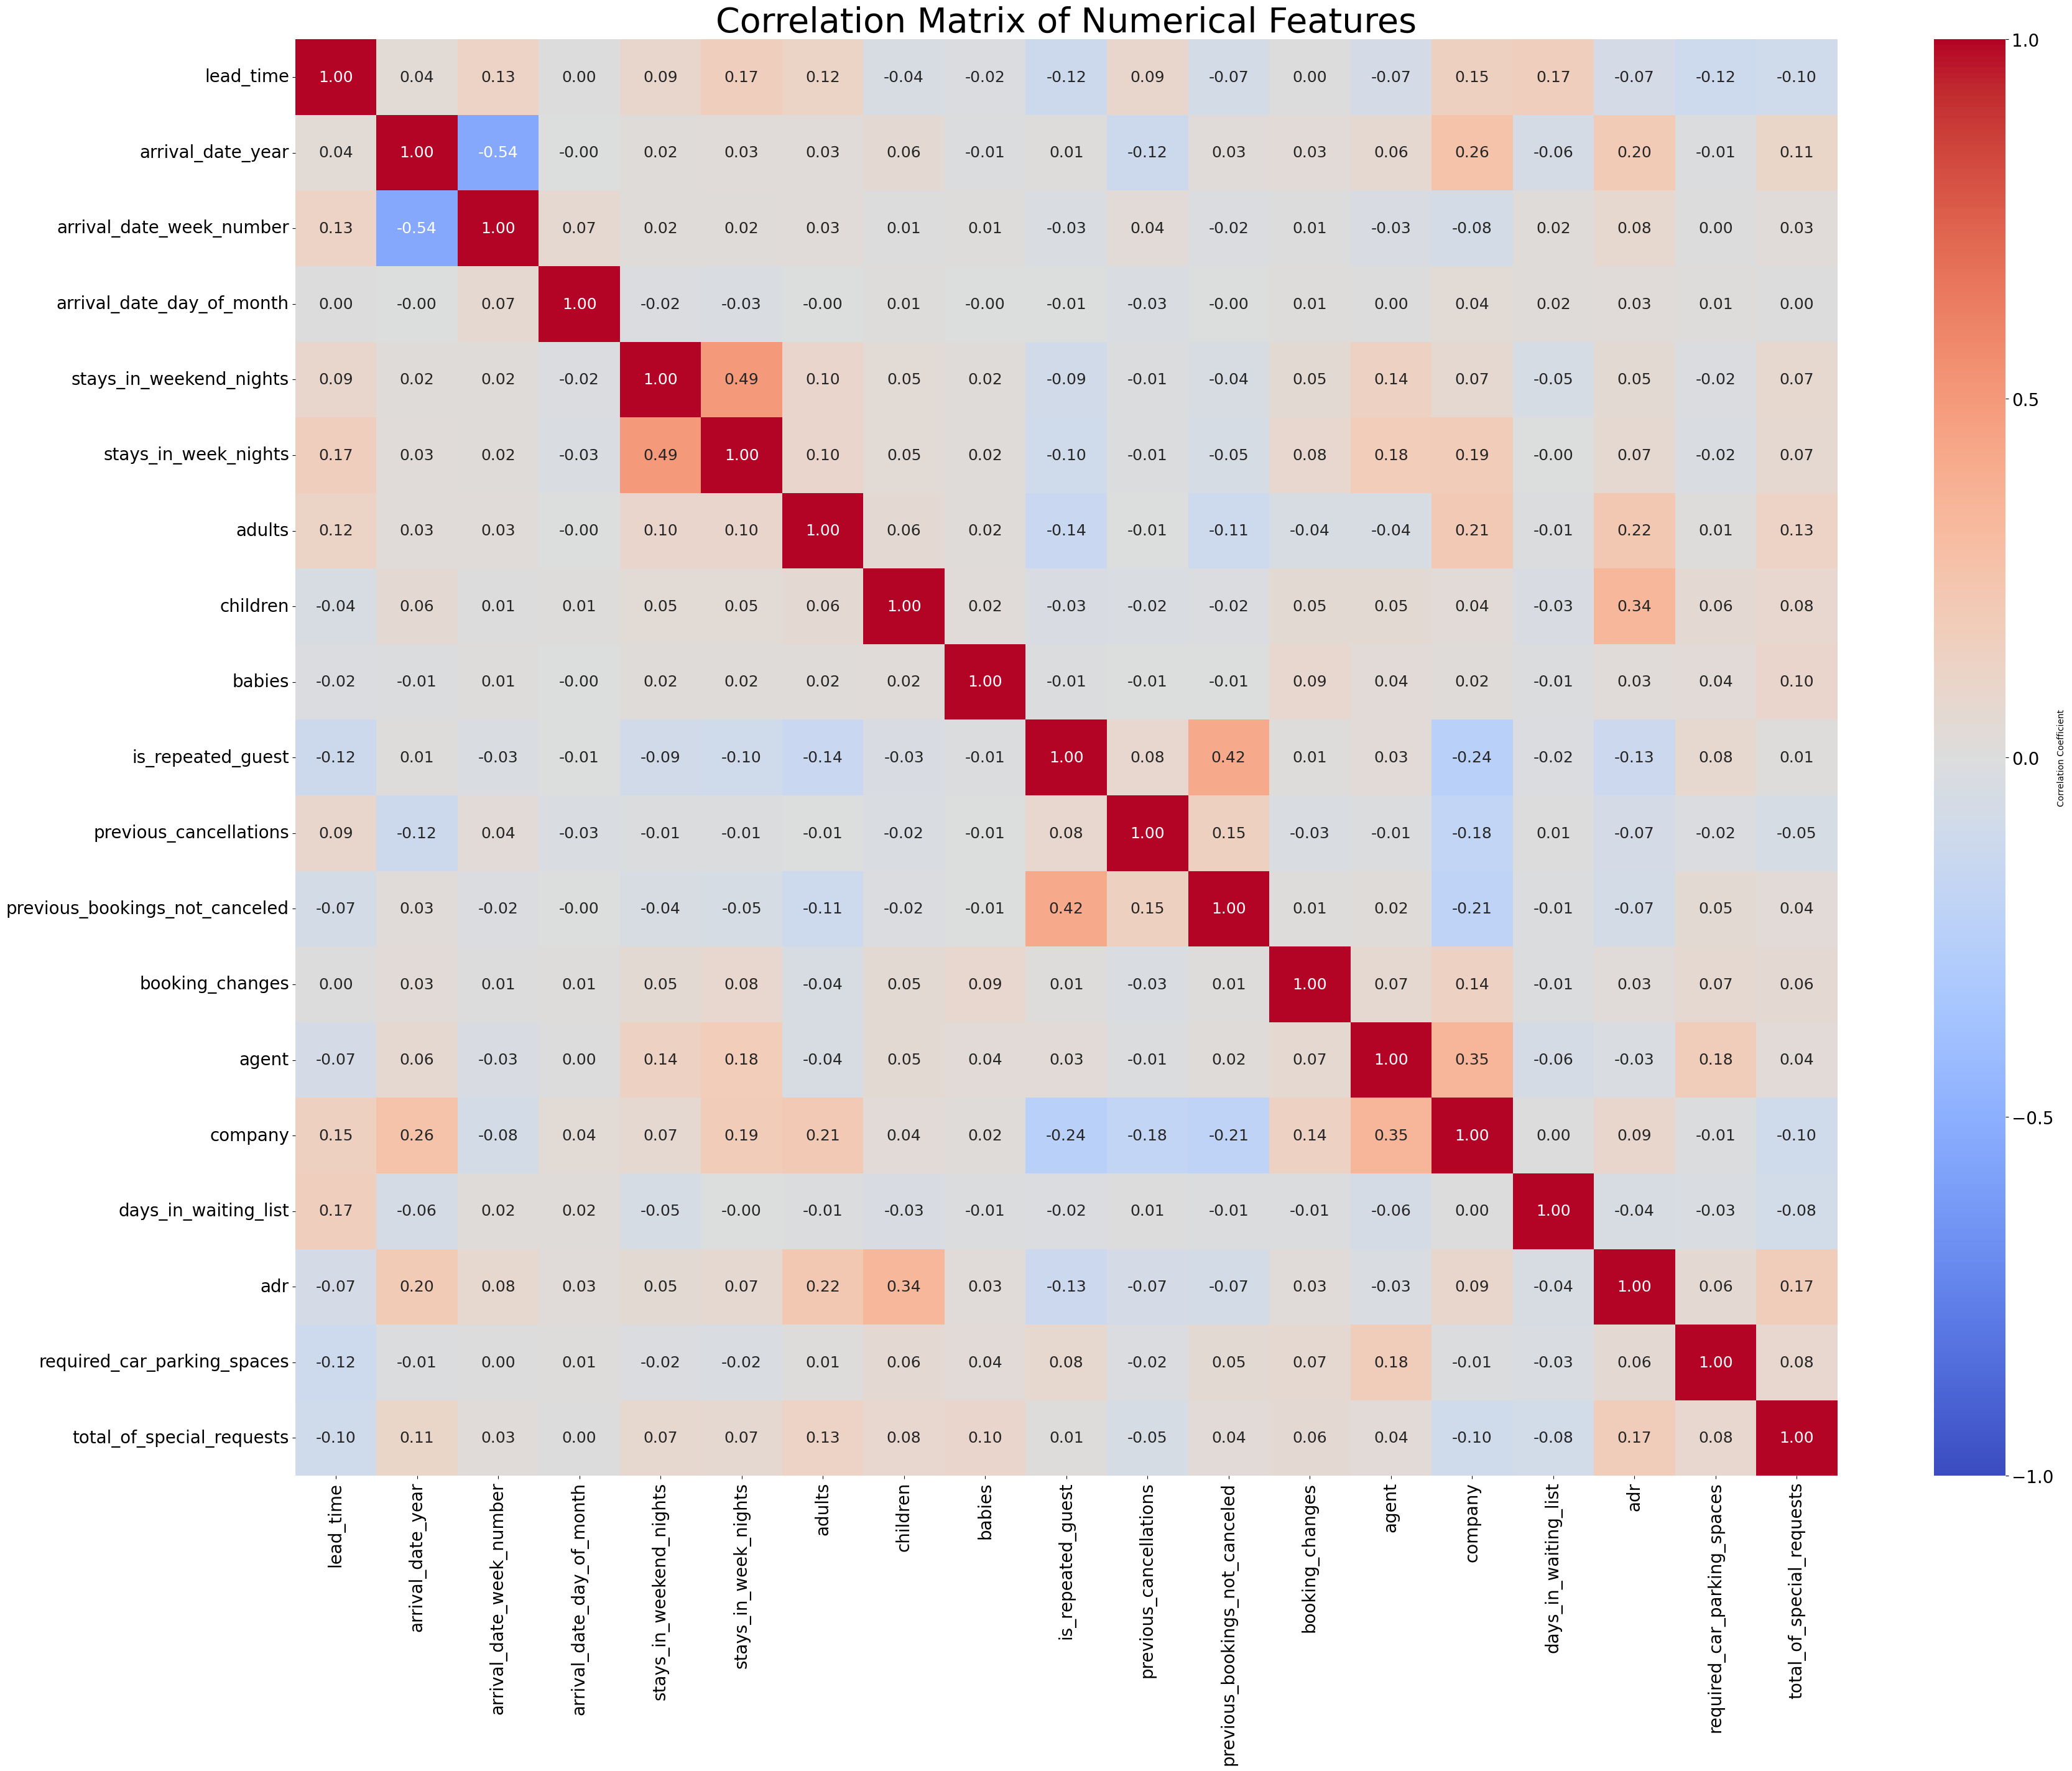

In [ ]:
correlation_matrix = df_clean[num_columns].corr()

plt.figure(figsize=(40, 30))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, annot_kws={"size": 18}, cbar_kws={'ticks': [-1, -0.5, 0, 0.5, 1], 'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix of Numerical Features", fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)
plt.show()

##### Correlation Between Featuren and Target Variable

###### 1. Numeric Features

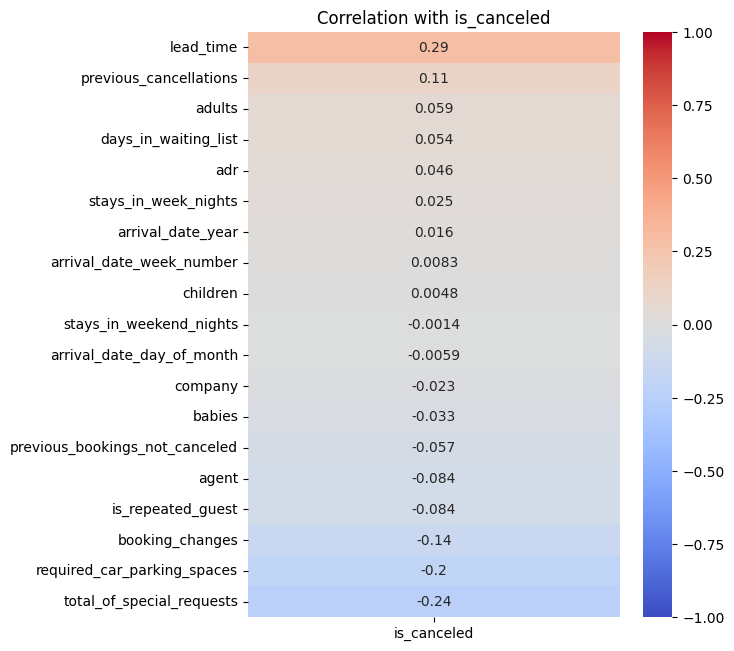

In [ ]:
correlation_data = df_clean[num_columns + [target_columns[0]]].corr()

correlation_with_target = correlation_data[[target_columns[0]]].drop(target_columns[0]).sort_values(by=target_columns[0], ascending=False)

plt.figure(figsize=(6, len(num_columns) * 0.4))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Correlation with {target_columns[0]}")
plt.show()

###### 2. Categorical Features

In [ ]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def cramers_v_matrix(df):
    n = len(cat_columns)
    matrix = pd.DataFrame(np.zeros((n, n)), index=cat_columns, columns=cat_columns)

    for i, col1 in enumerate(cat_columns):
        for j, col2 in enumerate(cat_columns):
            if i != j:
                matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
            else:
                matrix.loc[col1, col2] = 1.0

    return matrix

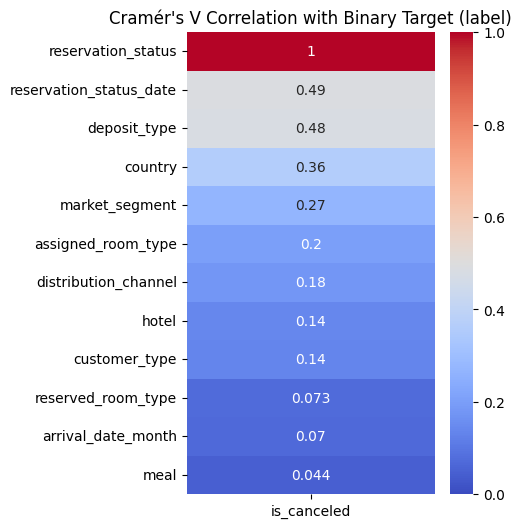

In [ ]:
cramers_v_values = {}

for col in cat_columns:
    cramers_v_values[col] = cramers_v(df_clean[col], df_clean[target_columns[0]])

cramers_v_df = pd.DataFrame(cramers_v_values, index=[target_columns[0]]).T.sort_values(by=target_columns[0], ascending=False)

plt.figure(figsize=(4, 6))
sns.heatmap(cramers_v_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Correlation with Binary Target (label)")
plt.show()

#### Deeper Visualization
Pada bagian ini akan dilakukan visualisasi lanjutan untuk memahami data lebih dalam.

##### 1. Cancellation Rate and Count by Hotel Type

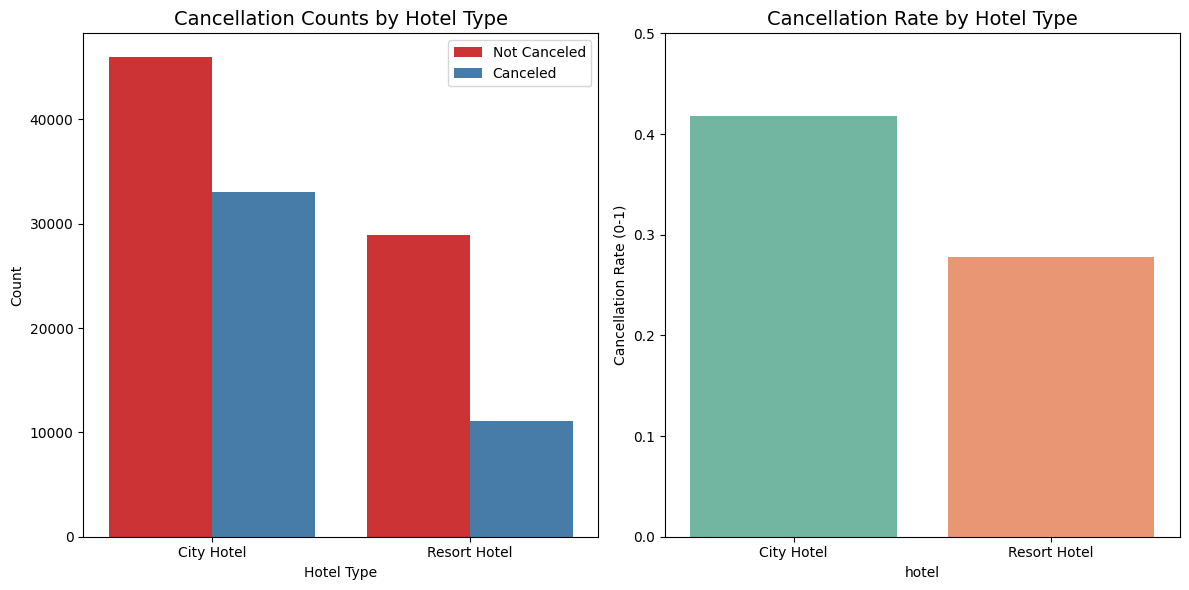

In [ ]:
plt.figure(figsize=(12, 6))

# A. Overall Cancellation Split
plt.subplot(1, 2, 1)
sns.countplot(data=df_clean, x='hotel', hue='is_canceled', palette='Set1')
plt.title('Cancellation Counts by Hotel Type', fontsize=14)
plt.xlabel('Hotel Type')
plt.ylabel('Count')
plt.legend(['Not Canceled', 'Canceled'])

# B. Cancellation Rate Comparison
plt.subplot(1, 2, 2)
cancel_rates = df_clean.groupby('hotel')['is_canceled'].mean().reset_index()
sns.barplot(data=cancel_rates, x='hotel', y='is_canceled', palette='Set2')
plt.title('Cancellation Rate by Hotel Type', fontsize=14)
plt.ylabel('Cancellation Rate (0-1)')
plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()

Terdapat perbedaan perilaku yang signifikan antara kedua jenis hotel. City Hotel memiliki volume pemesanan yang jauh lebih tinggi namun juga memiliki tingkat pembatalan (cancellation rate) yang lebih besar (sekitar 42%). Sebaliknya, Resort Hotel cenderung lebih stabil dengan tingkat pembatalan yang lebih rendah (sekitar 28%).

##### 2. Montly Arrival by Hotel Type

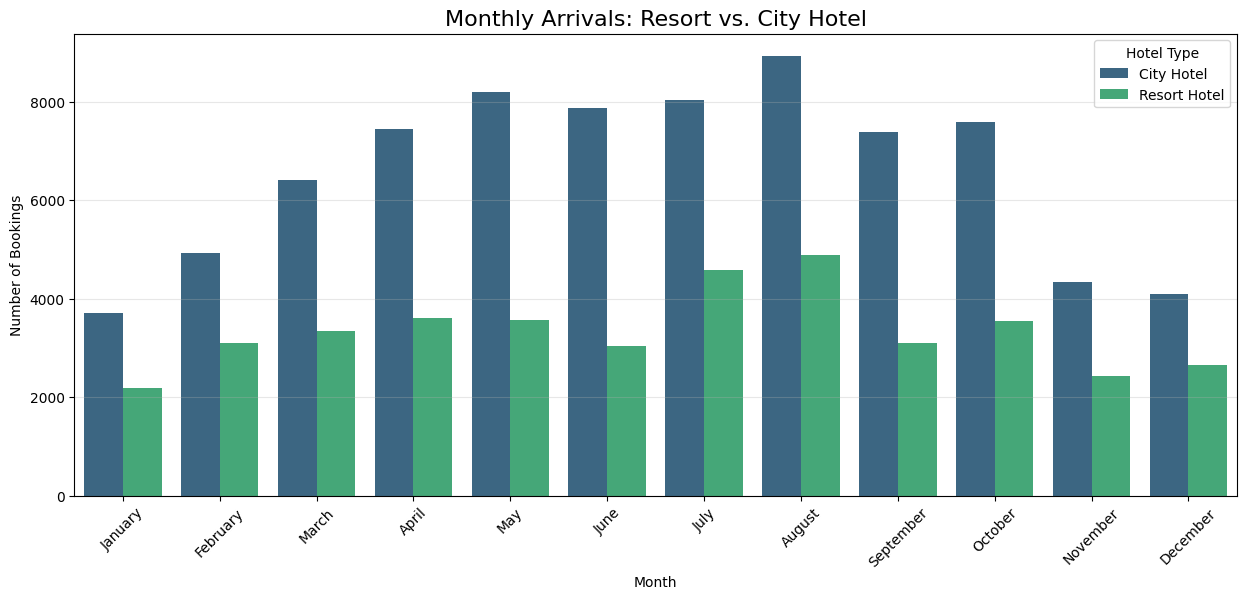

In [ ]:
# Order months correctly
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
df_clean['arrival_date_month'] = pd.Categorical(df_clean['arrival_date_month'], categories=months_order, ordered=True)

plt.figure(figsize=(15, 6))
sns.countplot(data=df_clean, x='arrival_date_month', hue='hotel', palette='viridis')
plt.title('Monthly Arrivals: Resort vs. City Hotel', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.legend(title='Hotel Type')
plt.grid(axis='y', alpha=0.3)
plt.show()

Pola musiman (seasonality) terlihat jelas pada Resort Hotel, di mana kunjungan melonjak tajam pada bulan Juli dan Agustus (musim panas). Sementara itu, City Hotel memiliki permintaan yang relatif tinggi dan konsisten sepanjang tahun, dengan sedikit penurunan di musim dingin, menunjukkan bahwa hotel kota tidak hanya bergantung pada turis liburan tetapi juga pebisnis.

##### 3. Correlation Between is_cancelled with days_before_arrival

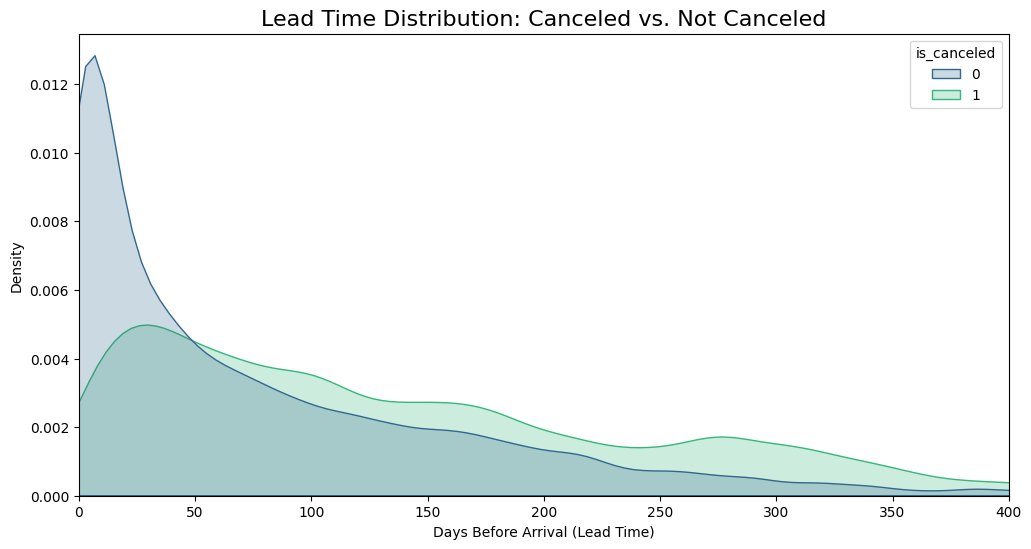

In [ ]:
plt.figure(figsize=(12, 6))

# Use a KDE plot to see the density distribution
sns.kdeplot(data=df_clean, x='lead_time', hue='is_canceled', fill=True, common_norm=False, palette='viridis')
plt.title('Lead Time Distribution: Canceled vs. Not Canceled', fontsize=16)
plt.xlim(0, 400) # Cap at 400 days to hide extreme long-tail
plt.xlabel('Days Before Arrival (Lead Time)')
plt.show()

 Semakin lama jarak waktu pemesanan (lead time), semakin tinggi risiko pembatalan. Grafik menunjukkan bahwa tamu yang memesan dalam waktu singkat (kurva hijau tinggi di kiri) cenderung tidak membatalkan pesanan. Sebaliknya, pemesanan yang dilakukan jauh-jauh hari (kurva biru melebar ke kanan) memiliki probabilitas pembatalan yang jauh lebih tinggi karena rencana tamu lebih mungkin berubah.

##### 4. Cancellation Rate by Deposit Type

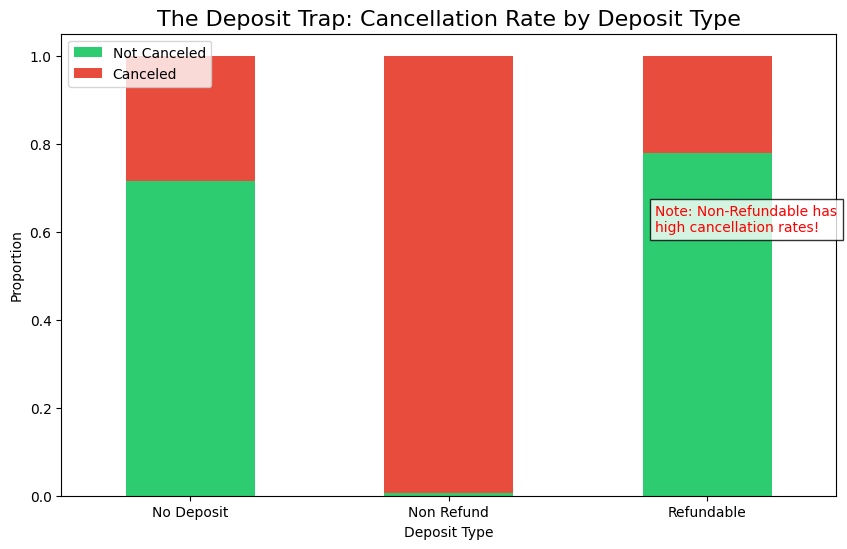

In [ ]:
# Calculate cancellation rates per deposit type
deposit_cancel_data = df_clean.groupby('deposit_type')['is_canceled'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
deposit_cancel_data.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], ax=plt.gca())
plt.title('The Deposit Trap: Cancellation Rate by Deposit Type', fontsize=16)
plt.ylabel('Proportion')
plt.xlabel('Deposit Type')
plt.legend(['Not Canceled', 'Canceled'], loc='upper left')
plt.xticks(rotation=0)

plt.text(1.8, 0.6, "Note: Non-Refundable has\nhigh cancellation rates!",
         fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

Ini adalah anomali terkenal dalam dataset ini. Tipe deposit "Non Refund" justru memiliki tingkat pembatalan yang hampir 100%. Hal ini berlawanan dengan intuisi, namun biasanya terjadi karena jenis deposit ini sering diterapkan pada pemesanan grup yang berisiko tinggi atau pemesanan fiktif yang akhirnya dibatalkan oleh sistem atau agen.

##### 5. Cancellation Rate and Market Segment

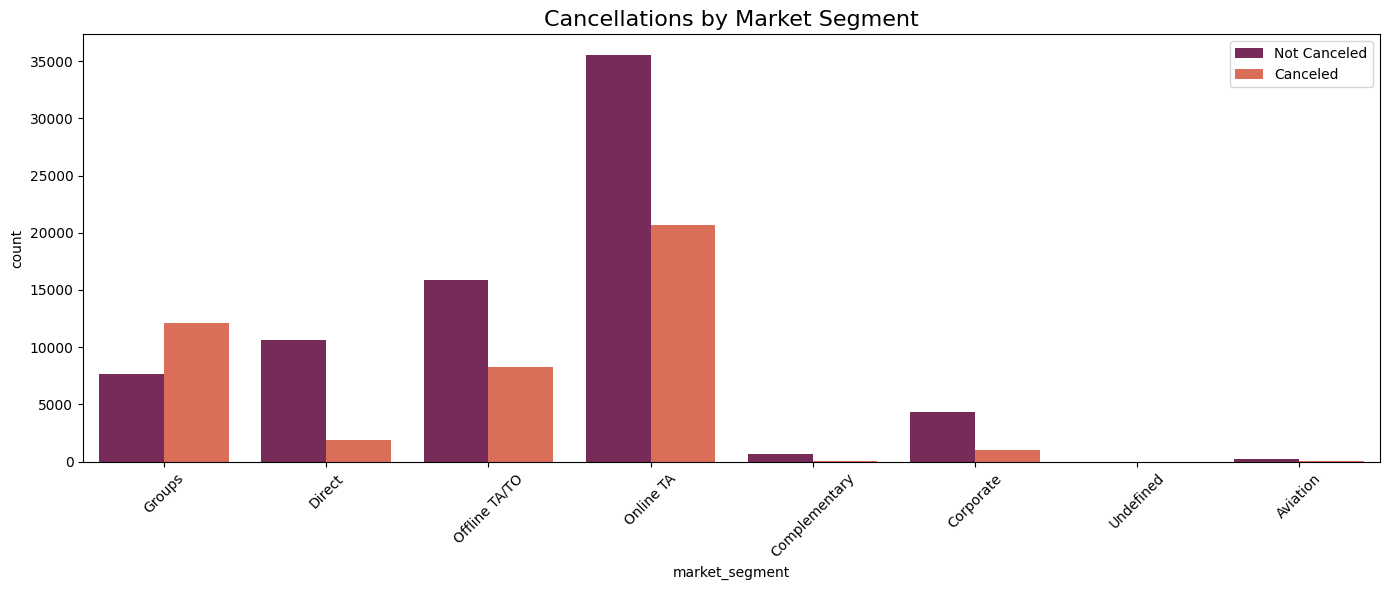

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_clean, x='market_segment', hue='is_canceled', palette='rocket')
plt.title('Cancellations by Market Segment', fontsize=16)
plt.xticks(rotation=45)
plt.legend(['Not Canceled', 'Canceled'])
plt.tight_layout()
plt.show()

Segmen "Online TA" (Travel Agent) adalah penyumbang volume terbesar namun memiliki jumlah pembatalan yang juga masif. Segmen "Groups" sangat berisiko dengan rasio pembatalan yang tinggi dibandingkan pemesanan suksesnya. Di sisi lain, segmen "Direct" (tamu yang memesan langsung ke hotel) dan "Corporate" adalah segmen paling setia dengan tingkat pembatalan yang sangat minim.

##### 6. The Effect of Room Mismatch to Cancellation Rate

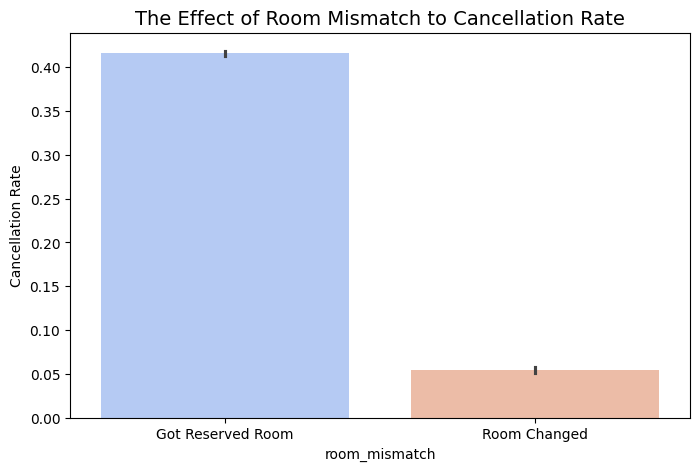

In [ ]:
# Create temporary mismatch column
df_clean['room_mismatch'] = df_clean['reserved_room_type'] != df_clean['assigned_room_type']

plt.figure(figsize=(8, 5))
sns.barplot(data=df_clean, x='room_mismatch', y='is_canceled', palette='coolwarm')
plt.title('The Effect of Room Mismatch to Cancellation Rate', fontsize=14)
plt.xticks([0, 1], ['Got Reserved Room', 'Room Changed'])
plt.ylabel('Cancellation Rate')
plt.show()

Grafik ini menunjukkan fenomena yang kontraintuitif namun menarik. Tamu yang mendapatkan kamar berbeda dari yang mereka pesan ("Room Changed") justru memiliki tingkat pembatalan yang sangat rendah (hanya sekitar 5%). Hal ini mungkin terjadi karena dalam operasional hotel, perubahan tipe kamar sering kali berarti upgrade gratis ke kamar yang lebih mahal/luas. Tamu yang menerima upgrade tentu merasa diuntungkan dan hampir tidak mungkin membatalkan pesanan, berbeda dengan tamu yang mendapatkan kamar sesuai pesanan awal ("Got Reserved Room") yang memiliki tingkat risiko pembatalan yang relatif normal.

# Split Training Set and Validation Set

In [ ]:
# Hapus row dengan nilai adults = 0 (Pemesanan Palsu)
df_train = df_train[df_train['adults'] != 0]

In [ ]:
X_train = df_train.drop(target_columns, axis=1)
y_train = df_train[target_columns]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Data Cleaning and Preprocessing


## A. Data Cleaning

### I. Data Quality Improvement

Pada bagian ini akan dilakukan peningkatan kualitas data sesuai dengan yang sudah ditemukan di EDA:
1. Menggabungkan jenis SC dan Undefined di kolom Meal.
2. Hanya mengambil 15 Negara tertinggi, sisanya dimasukkan jenis Other.

In [ ]:
class InitialCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, top_n_countries=15):
        self.top_n_countries = top_n_countries
        self.top_countries_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Logika untuk mempelajari Top N Countries dari data training
        if 'country' in X.columns:
            # Hitung frekuensi negara
            country_counts = X['country'].value_counts()
            # Simpan daftar nama negara top N ke dalam atribut class
            self.top_countries_ = country_counts.head(self.top_n_countries).index.tolist()

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_clean = X.copy()

        # # 1. Drop pemesanan palsu (Adults == 0)
        # if 'adults' in X_clean.columns:
        #     mask = X_clean['adults'] != 0
        #     X_clean = X_clean[mask]

        # 2. Fix Meal Category (Undefined = SC)
        if 'meal' in X_clean.columns:
            X_clean['meal'] = X_clean['meal'].replace("Undefined", "SC")

        # 3. Group Rare Countries to 'Other'
        if 'country' in X_clean.columns and self.top_countries_ is not None:
            X_clean.loc[~X_clean['country'].isin(self.top_countries_), 'country'] = 'Other'

        return X_clean

### II. Handling Missing Data

In [ ]:
class NumMissingValueHandler(BaseEstimator, TransformerMixin):
  def __init__(self):
      # Daftar kolom yang secara logika harus diisi 0 jika kosong
      # agent/company: 0 = Booking langsung/Pribadi
      # children/requests/parking: 0 = Tidak ada
      self.zero_impute_cols = [
          'agent', 'company', 'children', 'babies',
          'required_car_parking_spaces', 'total_of_special_requests'
      ]

  def fit(self, X, y=None):
      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X)

      self.feature_names_in_ = X.columns.tolist() if hasattr(X, 'columns') else [f"x{i}" for i in range(X.shape[1])]
      self.imputers_ = {}

      for column in X.columns:
          # 1. Jika kolom ID atau Count tertentu -> Isi dengan 0
          if column in self.zero_impute_cols:
              imputer = SimpleImputer(strategy='constant', fill_value=0)

          # 2. Sisanya (Lead time, ADR, dll) -> Isi dengan Median
          # Median dipilih karena data hotel ini memiliki banyak outlier (skewed)
          else:
              imputer = SimpleImputer(strategy='median')

          imputer.fit(X[[column]])
          self.imputers_[column] = imputer

      return self

  def transform(self, X, y=None):
      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X, columns=self.feature_names_in_)

      X = X.copy()

      for column in X.columns:
          if column in self.imputers_:
              X[column] = self.imputers_[column].transform(X[[column]]).ravel()

      return X

  def get_feature_names_out(self, input_features=None):
      if input_features is None:
          return np.array(self.feature_names_in_)
      return np.array(input_features)

In [ ]:
class CatMissingValueHandler(BaseEstimator, TransformerMixin):
  def __init__(self):
      pass

  def fit(self, X, y=None):
      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X)

      self.feature_names_in_ = X.columns.tolist() if hasattr(X, 'columns') else [f"x{i}" for i in range(X.shape[1])]

      self.fill_values_ = {}

      for col in X.columns:
          # Jika kolom Country, fill value adalah 'Other'
          if col == 'country':
              self.fill_values_[col] = 'Other'

          else:
              # Cek modus, ambil nilai pertama. Jika series kosong, default 'Missing'
              mode_val = X[col].mode()
              if not mode_val.empty:
                  self.fill_values_[col] = mode_val[0]
              else:
                  self.fill_values_[col] = "Missing"

      return self

  def transform(self, X, y=None):
      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X, columns=self.feature_names_in_)

      X = X.copy()

      for col, fill_val in self.fill_values_.items():
          if col in X.columns:
              X[col] = X[col].fillna(fill_val)

      return X

  def get_feature_names_out(self, input_features=None):
      if input_features is None:
          return np.array(self.feature_names_in_)
      return np.array(input_features)

Terdapat dua kolom kategori yang diimpute: agent dan country. Dari penjelasan dataset, diketahui bahwa missing value pada agent berarti booking dilakukan langsung. Sedangkan untuk country akan dimasukkan ke kelas baru, yaitu other.

### III. Dealing with Outliers

In [ ]:
class OutlierHandler(BaseEstimator, TransformerMixin):
  def __init__(self):
      # nilai max cap heuristik
      self.caps_ = {
          'adults': 10,       # lebih dari 10 orang sekamar itu aneh
          'children': 10,
          'babies': 5,
          'adr': 1000,
          'total_of_special_requests': 5,
          'required_car_parking_spaces': 5
      }

  def fit(self, X, y=None):
      self.feature_names_in_ = X.columns.tolist() if hasattr(X, 'columns') else [f"x{i}" for i in range(X.shape[1])]
      return self

  def transform(self, X, y=None):
      if not isinstance(X, pd.DataFrame):
          X = pd.DataFrame(X)

      X_out = X.copy()

      for col, max_val in self.caps_.items():
          if col in X_out.columns:
              # Jika nilai > max_val, ubah menjadi max_val
              X_out[col] = np.where(X_out[col] > max_val, max_val, X_out[col])

      return X_out

  def get_feature_names_out(self, input_features=None):
      if input_features is None:
          return np.array(self.feature_names_in_)
      return np.array(input_features)

Penentuan nilai batas untuk kolom-kolom tertentu dilakukan dengan menggunakan metode heuristik (menggunakan logika).

### III. Dealing with Outliers

### IV. Feature Engineering

#### A. Remove Useless Attribute

In [ ]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(["reservation_status","reservation_status_date","company"], axis=1)

Hapus kolom company karena terlalu banyak missing value. Hapus reservation_status dan reservation_status_date untuk menghindari leakage ke is_cancelled.

#### B. Adding New Feature

In [ ]:
class FeatureEngineerer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # 1. Total Guests (Strong predictor)
        X['total_guests'] = X['adults'] + X['children'] + X['babies']

        # 2. Total Stay Duration
        X['total_nights'] = X['stays_in_week_nights'] + X['stays_in_weekend_nights']

        # 3. Room Mismatch (Did they get what they asked for?)
        X['room_mismatch'] = (X['reserved_room_type'] != X['assigned_room_type']).astype(int)

        # 4. Family Flag
        X['is_family'] = ((X['children'] > 0) | (X['babies'] > 0)).astype(int)

        return X

Menambahkan beberapa fitur tambahan:
1. total_guests
2. total_nights
3. room_mismatch: apakah ruangan yang didapat sesuai booking
4. is_family: apakah membawa keluarga

## B. Data Preprocessing
Preprocessing akan langsung di tambahkan ke pipeline utama di bagian setelah ini.

# 3. Compile Preprocessing Pipeline

In [ ]:
num_columns.remove('company')
cat_columns.remove('reservation_status_date')
cat_columns.remove('reservation_status')

In [ ]:
from sklearn.preprocessing import RobustScaler


cat_pipeline = Pipeline([
    ('imputer', CatMissingValueHandler()),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_pipeline = Pipeline([
    ('imputer', NumMissingValueHandler()),
    ('numClipper', OutlierHandler()),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('Scaler', RobustScaler())
])

num_cat_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

num_cat_pipeline.set_output(transform="pandas")

final_pipeline = Pipeline([
    ('initial_cleaner', InitialCleaner(top_n_countries=15)),
    ('column_dropper', ColumnDropper()),
    ('preprocessing', num_cat_pipeline)
])

In [ ]:
X_train_prepared = final_pipeline.fit_transform(X_train, y_train)
X_test_prepared = final_pipeline.transform(X_val)

# 4. Modeling and Validation

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

y_train_enc = y_train.values.ravel()
y_val_enc = y_val.values.ravel()

In [ ]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'max_iter': 1000,
        'random_state': 42
    }

    model = LogisticRegression(**params)
    model.fit(X_train_prepared, y_train_enc)

    preds = model.predict(X_test_prepared)
    accuracy = accuracy_score(y_val_enc, preds)
    return accuracy

print("Hyperparameter Tuning Logistic Regression")
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100)
print(f"Best Params Logistic Regression: {study_lr.best_params}")
print(f"Best Accuracy Logistic Regression: {study_lr.best_value:.4f}\n")

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_prepared, y_train_enc)

    preds = model.predict(X_test_prepared)
    accuracy = accuracy_score(y_val_enc, preds)
    return accuracy

print("Hyperparameter Tuning Random Forest")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)
print(f"Best Params Random Forest: {study_rf.best_params}")
print(f"Best Accuracy Random Forest: {study_rf.best_value:.4f}\n")


def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 30
    }

    model = XGBClassifier(**params)

    model.fit(
        X_train_prepared,
        y_train_enc,
        eval_set=[(X_test_prepared, y_val_enc)],
        verbose=False
    )

    preds = model.predict(X_test_prepared)
    accuracy = accuracy_score(y_val_enc, preds)
    return accuracy

print("Hyperparameter Tuning XGBoost")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)
print(f"Best Params XGBoost: {study_xgb.best_params}")
print(f"Best Accuracy XGBoost: {study_xgb.best_value:.4f}\n")

print("Hasil Hyperparameter Tuning")
print(f"Logistic Regression: {study_lr.best_value:.4f}")
print(f"Random Forest: {study_rf.best_value:.4f}")
print(f"XGBoost: {study_xgb.best_value:.4f}")

[I 2025-12-11 11:18:12,133] A new study created in memory with name: no-name-11b347d7-2a6b-44f5-854a-0e1efffcbcaa


Hyperparameter Tuning Logistic Regression


[I 2025-12-11 11:18:14,265] Trial 0 finished with value: 0.841712634620436 and parameters: {'C': 0.032816162180803354, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.841712634620436.
[I 2025-12-11 11:18:16,246] Trial 1 finished with value: 0.8376149198844234 and parameters: {'C': 0.0026284597367343242, 'solver': 'liblinear'}. Best is trial 0 with value: 0.841712634620436.
[I 2025-12-11 11:18:23,490] Trial 2 finished with value: 0.8440241660099816 and parameters: {'C': 0.8215487311289246, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.8440241660099816.
[I 2025-12-11 11:18:31,757] Trial 3 finished with value: 0.8436564223798266 and parameters: {'C': 0.4484696335268267, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.8440241660099816.
[I 2025-12-11 11:18:37,672] Trial 4 finished with value: 0.8437614919884423 and parameters: {'C': 0.3556708490301546, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.8440241660099816.
[I 2025-12-11 11:18:39,640] Trial 5 finished with value: 0.84055

Best Params Logistic Regression: {'C': 6.46813777925143, 'solver': 'lbfgs'}
Best Accuracy Logistic Regression: 0.8466

Hyperparameter Tuning Random Forest


[I 2025-12-11 11:28:30,301] Trial 0 finished with value: 0.8336222747570265 and parameters: {'n_estimators': 224, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8336222747570265.
[I 2025-12-11 11:28:56,300] Trial 1 finished with value: 0.8902547938008931 and parameters: {'n_estimators': 293, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8902547938008931.
[I 2025-12-11 11:29:26,009] Trial 2 finished with value: 0.8995009193590754 and parameters: {'n_estimators': 291, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8995009193590754.
[I 2025-12-11 11:29:32,213] Trial 3 finished with value: 0.7777252429734699 and parameters: {'n_estimators': 203, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8995009193590754.
[I 2025-12-11 11:29:43,575] Trial 4 finished with value: 0.9015497767270817 and parameters: {

Best Params Random Forest: {'n_estimators': 291, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Accuracy Random Forest: 0.9147

Hyperparameter Tuning XGBoost


[I 2025-12-11 12:05:22,376] Trial 0 finished with value: 0.8811662726556344 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.17681781093799048, 'subsample': 0.8412903678703272, 'colsample_bytree': 0.6635844353409596, 'gamma': 4.12200023782526, 'reg_alpha': 6.729124494737448, 'reg_lambda': 1.5049049326827624}. Best is trial 0 with value: 0.8811662726556344.
[I 2025-12-11 12:05:30,995] Trial 1 finished with value: 0.8864197530864197 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.028779086325303856, 'subsample': 0.69515387234182, 'colsample_bytree': 0.7199518615068109, 'gamma': 4.698633946192126, 'reg_alpha': 5.8916054269205, 'reg_lambda': 1.9579735914188845}. Best is trial 1 with value: 0.8864197530864197.
[I 2025-12-11 12:05:37,623] Trial 2 finished with value: 0.8954557394273707 and parameters: {'n_estimators': 127, 'max_depth': 10, 'learning_rate': 0.04664803952135461, 'subsample': 0.6156813790599762, 'colsample_bytree': 0.943964279672

Best Params XGBoost: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.16342802729741931, 'subsample': 0.9440447396399663, 'colsample_bytree': 0.7422161132970942, 'gamma': 0.13247505415284713, 'reg_alpha': 0.380620896437301, 'reg_lambda': 0.8982764996493284}
Best Accuracy XGBoost: 0.9137

Hasil Hyperparameter Tuning
Logistic Regression: 0.8466
Random Forest: 0.9147
XGBoost: 0.9137


Model Evaluation:
Classification Report Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11299
           1       0.85      0.75      0.80      7736

    accuracy                           0.85     19035
   macro avg       0.85      0.83      0.84     19035
weighted avg       0.85      0.85      0.84     19035

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     11299
           1       0.93      0.86      0.89      7736

    accuracy                           0.91     19035
   macro avg       0.92      0.91      0.91     19035
weighted avg       0.92      0.91      0.91     19035

Classification Report XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     11299
           1       0.91      0.87      0.89      7736

    accuracy                           0.91     19035

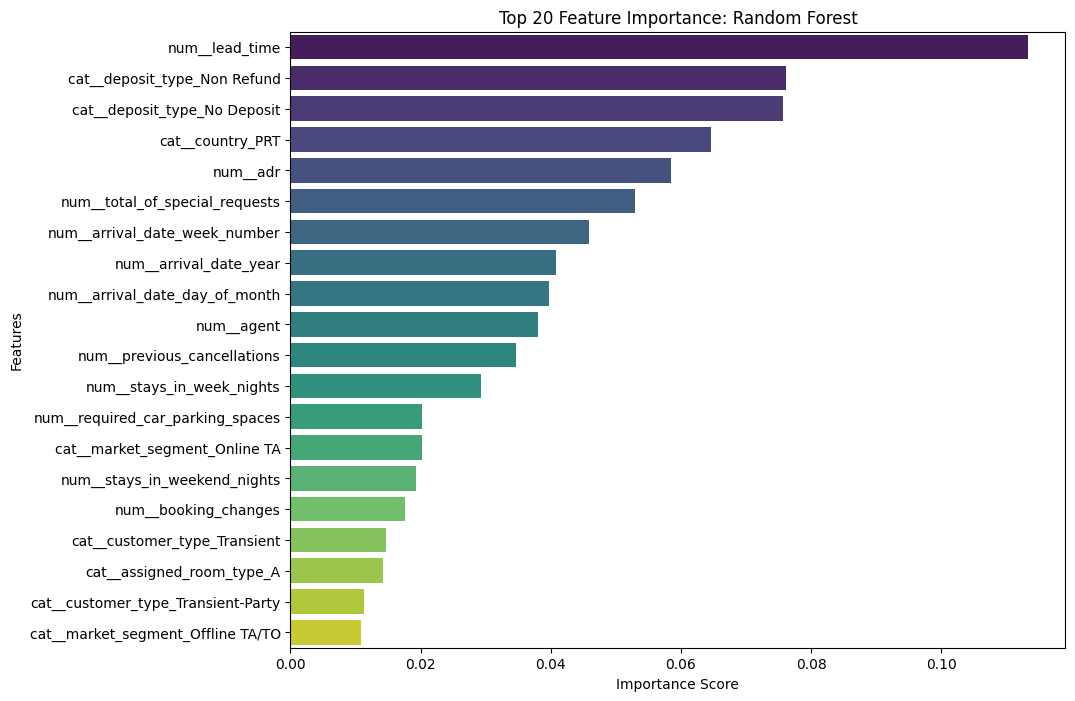

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=6.46813777925143, solver='lbfgs'),
    "Random Forest": RandomForestClassifier(n_estimators=291, max_depth=35, min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1, early_stopping_rounds=30, n_estimators=219, max_depth=9, learning_rate= 0.16342802729741931, subsample=0.9440447396399663, colsample_bytree=0.7422161132970942, gamma=0.13247505415284713, reg_alpha=0.380620896437301, reg_lambda=0.8982764996493284)
}

final_results = []
feature_importance_dict = {}

print("Model Evaluation:")
for name, model in models.items():
    if name != "XGBoost":
      model.fit(X_train_prepared, y_train_enc)
    else:
      model.fit(
        X_train_prepared,
        y_train_enc,
        eval_set=[(X_test_prepared, y_val_enc)],
        verbose=False
      )

    y_pred = model.predict(X_test_prepared)
    acc = accuracy_score(y_val_enc, y_pred)
    roc = roc_auc_score(y_val_enc, y_pred)

    final_results.append({
        "Model": name,
        "Accuracy": acc,
        "ROC-AUC": roc
    })

    print(f"Classification Report {name}:")
    print(classification_report(y_val_enc, y_pred))

    feature_names = X_train_prepared.columns

    if name == "Logistic Regression":
        importance = np.abs(model.coef_[0])
    else:
        importance = model.feature_importances_

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    feature_importance_dict[name] = feat_imp_df

print("Evaluation Results:")
results_df = pd.DataFrame(final_results).sort_values(by='Accuracy', ascending=False)
print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\nVisualizing Feature Importance for Best Model: {best_model_name}")

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_dict[best_model_name].head(20),
    palette='viridis'
)
plt.title(f'Top 20 Feature Importance: {best_model_name}')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()